In [7]:
conda install -c conda-forge xgboost

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    conda-4.10.3               |   py38h50d1736_0         3.1 MB  conda-forge
    libxgboost-1.3.3           |       h23ab428_0         1.2 MB
    py-xgboost-1.3.3           |   py38hecd8cb5_0         136 KB
    python_abi-3.8             |           2_cp38           4 KB  conda-forge
    xgboost-1.3.3              |   py38hecd8cb5_0          23 KB
    ------------------------------------------------------------
                                           Total:  

In [1]:
import xgboost as xgb

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score

In [12]:
test_data=pd.read_csv('/Users/jinglinhui/Desktop/Data_analytics_project/log_regression/test.csv')
train_data=pd.read_csv('/Users/jinglinhui/Desktop/Data_analytics_project/log_regression/train.csv')

In [13]:
train_data['Age'] = train_data.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.mean()))
train_data["Embarked"].fillna(train_data['Embarked'].value_counts().idxmax(), inplace=True)

In [14]:
train_data.drop("Cabin", inplace=True, axis=1)
train_data.drop(['PassengerId'], axis=1,inplace=True)
train_data.drop("Name", inplace=True, axis=1)
train_data.drop("Ticket", inplace=True, axis=1)


In [15]:
train_data["Sex"] = train_data["Sex"].map({'male':1, 'female':0})
embarked =pd.get_dummies(train_data['Embarked'],drop_first=True)
train_data = pd.concat([train_data, embarked], axis=1)
train_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Q,S
0,0,3,1,22.00,1,0,7.2500,S,0,1
1,1,1,0,38.00,1,0,71.2833,C,0,0
2,1,3,0,26.00,0,0,7.9250,S,0,1
3,1,1,0,35.00,1,0,53.1000,S,0,1
4,0,3,1,35.00,0,0,8.0500,S,0,1
...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.00,0,0,13.0000,S,0,1
887,1,1,0,19.00,0,0,30.0000,S,0,1
888,0,3,0,21.75,1,2,23.4500,S,0,1
889,1,1,1,26.00,0,0,30.0000,C,0,0


In [16]:
train_data.drop("Embarked", inplace=True, axis=1)

In [17]:
train_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Q           0
S           0
dtype: int64

In [18]:
test_data['Age'] = test_data.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.mean()))
test_data["Embarked"].fillna(test_data['Embarked'].value_counts().idxmax(), inplace=True)
test_data["Sex"] = test_data["Sex"].map({'male':1, 'female':0})
embarked_test = pd.get_dummies(test_data["Embarked"], drop_first=True)
test_data = pd.concat([test_data, embarked_test], axis=1)
test_data["Fare"].fillna(test_data["Fare"].mean(skipna=True), inplace=True)

In [19]:
test_data = test_data.drop(['PassengerId'], axis=1)
test_data.drop('Cabin', axis=1, inplace=True)
test_data.drop("Name", inplace=True, axis=1)
test_data.drop("Ticket", inplace=True, axis=1)
test_data.drop("Embarked", inplace=True, axis=1)

In [20]:
test_data.isnull().sum()

Pclass    0
Sex       0
Age       0
SibSp     0
Parch     0
Fare      0
Q         0
S         0
dtype: int64

In [21]:
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data["Survived"]

In [22]:
data_dmatrix = xgb.DMatrix(data=X_train,label=Y_train)

In [28]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3, num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[18:39:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[18:39:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[18:39:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [29]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.496890,0.000643,0.496990,0.000355
1,0.489211,0.005586,0.490213,0.005823
2,0.484676,0.003733,0.485718,0.004456
3,0.478115,0.007627,0.480062,0.008477
4,0.474597,0.009066,0.477134,0.009627


In [30]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.397938
Name: test-rmse-mean, dtype: float64


In [31]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[18:41:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


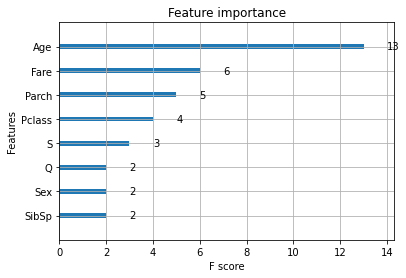

In [32]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [48]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [49]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        data_dmatrix,
        num_boost_round=10,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=9, min_child_weight=5
[21:24:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:24:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:24:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:24:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:24:13] WARNING: /opt/concourse/worker/volume

In [38]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [45]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        data_dmatrix,
        num_boost_round=100,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
[21:23:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:23:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:23:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:23:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:23:28] WARNING: /opt/concourse/worker/volumes/l

	MAE 0.2953308 for 99 rounds
CV with subsample=0.9, colsample=0.7
[21:23:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:23:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:23:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:23:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:23:30] WARNING: /o

	MAE 0.29687100000000005 for 99 rounds
CV with subsample=0.7, colsample=0.8
[21:23:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:23:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:23:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:23:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:23:33] W

In [53]:
params_opt = {'colsample_bytree': 1,'learning_rate': 0.9,
                'max_depth': 9}

In [54]:
xg_reg = xgb.train(params=params_opt, dtrain=data_dmatrix, num_boost_round=100)

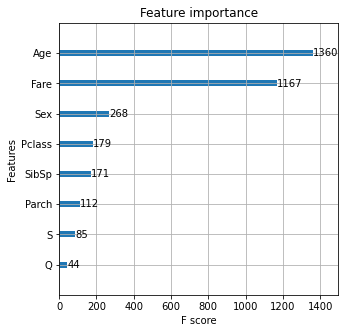

In [55]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()